# hera_sim for large, accurate, simulations



Hugh Garsden, HERA Group, Queen Mary University of London


# 1. Introduction



## Motivation

We are using hera_sim for simulations of HERA beam perturbations, as the hera_sim interface is fairly simple and transparent.  We added analytic beam interpolation (so we can implement the Fagnoni beam). However, the output from hera_sim dosn't match the output from pyuvsim, which is the "gold standard" for accuracy. We could switch to pyuvsim, but it is slow and memory-intensive compared to hera_sim. We investigated whether we could make hera_sim more accurate, and maintain its performance.

Note that although pyuvsim can be parallelized with MPI, we also added MPI parallelization to hera_sim. Therefore, hera_sim is still faster than pyuvsim. For this notebook, parallized simulations are not used.

## Outline

Section 2 establishes functions and objects to make the simulations and analysis manageable. There is a function to compare hera_sim and pyuvsim output values, and a function to setup simulation objects for different configurations.

Section 3 runs small simulations and compares the hera_sim and pyuvsim output values and simulation times. It's divided into parts:

- Compare original hera_sim and pyuvsim using a couple of values, and a plot of a baseline.
- Compare enhanced hera_sim and pyuvsim in the same way.

Section 4 runs some variations on the test in Section 3, to show that the results are general.

Section 5 shows the results of scaling tests, showing how simulation time and memeory use change as simulations increase in size. 

## Short Summary of Results

The enhanced hera_sim is >100 times faster than pyuvsim, and the output visibilities match pyuvsim to many decimal places. As an example, compare the autocorrelation of antenna 0,and cross-correlation between antennas 0,1, for a particular simulation:
<pre>
		                         pyuvsim 			        hera_sim
Auto corr ant 0 (Amplitude)      0.25656533815007254         0.25656533815007254
Cross corr ant (0,1) Amplitude   0.17087283751552645         0.17087283751552657
Cross corr ant (0,1) Phase       0.384381003442964           0.3843810034429456
</pre>

Other simulations show that these results are general.

The enhanced hera_sim uses less memory than pyuvsim. This is a plot of hera_sim and pyuvsim memory usage, by number of frequency channels in the simulation:

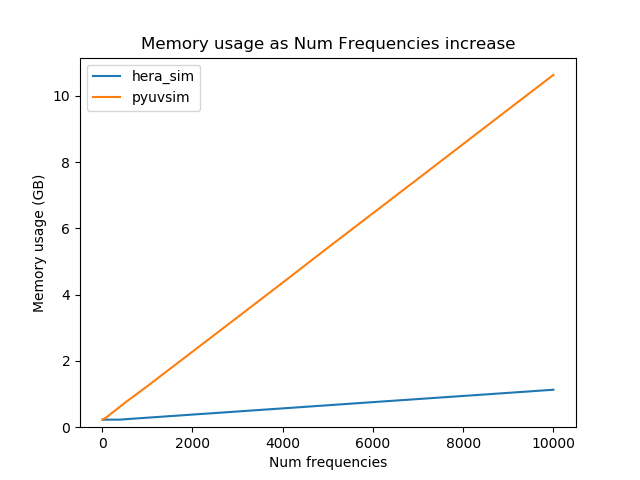



## Caveats

The enhanced hera_sim contains Astropy code, and some parts of that code have been hardwired for HERA. Therefore, if Astropy changes, enhanced hera_sim will need updating, and it can only be used for HERA.

# 2. Initialization and setup

Define some functions to setup telescope and observing configuration. Return appropriate simulation objects for hera_sim and pyuvsim.

We use the [polybeam-astropy](https://github.com/HERA-Team/hera_sim/tree/polybeam-astropy/hera_sim) branch of hera_sim, which has these enhancements:
- The original hera_sim is still supported, so it can be run
- Analytic beams can be used. It was designed for use with the Fagnoni beam (class PolyBeam and PerturbedPolyBeam) but can be used 
  with other beams like AnalyticBeam. PerturbedPolyBeam  will be used for these tests. pyuvsim is able to call it.
- More accurate beam interpolation can be used. This was achieved by adding some astropy code to hera_sim. It can only be used for HERA telescope because some shortcuts were made (although these are not the sole reason for the improved accuracy).
- Simulations can be run using MPI. This is not demonstrated for the tests here, only serial versions are used. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from hera_sim.visibilities import VisCPU
from hera_sim import io
from hera_sim.beams import PerturbedPolyBeam
from astropy.coordinates import Latitude, Longitude
from astropy.units import Quantity
import numpy as np
from pyuvsim import uvsim
from pyuvsim.telescope import BeamList
from pyradiosky import SkyModel
from pyuvsim import simsetup
import healvis as hv
import time

plt.rcParams['figure.figsize'] = [12, 6]

def compare_val(puvsim_uvd, hera_sim_uvd, ant1=0, ant2=1, which_freq=0, which_time=0):
    """
    Compare the outputs of two simulations, using a couple of values.
    uvd1 and uvd2 are UVData objects from the simulations. Extract the 
    autocorrelation of antenna 0 and the cross-correlation between antennas 0:1
    and print the values. Values are converted to amplitude and phase.
    Print a table with values from uvd1 in the first column and uvd2 in the second
    column.
    """
   
    sim1_auto = puvsim_uvd.get_data(ant1, ant1, "XX")[which_time][which_freq]
    sim1_cross = puvsim_uvd.get_data(ant1, ant2, "XX")[which_time][which_freq]
    sim2_auto = hera_sim_uvd.get_data(ant1, ant1, "XX")[which_time][which_freq]
    sim2_cross = hera_sim_uvd.get_data(ant1, ant2, "XX")[which_time][which_freq]
    
    print("\n---------------------------------- Accuracy --------------------------------------")
    print("Values from Channel", which_freq, "Time", which_time)
    print("\t\t\t\t pyuvsim \t\t\t hera_sim")
    print("Auto corr ant "+str(ant1), "\t\t", abs(sim1_auto), "\t\t", abs(sim2_auto)) 
    print("Cross corr ant ("+str(ant1)+","+str(ant2)+") Amplitude", "\t", abs(sim1_cross), "\t\t", abs(sim2_cross))
    print("Cross corr ant ("+str(ant1)+","+str(ant2)+") Phase", "\t", np.angle(sim1_cross), "\t\t", np.angle(sim2_cross))
    print("\n\n")

def compare_baseline(puvsim_uvd, hera_sim_uvd, ant1=0, ant2=0, which_time=0):
    """
    Plot amplitude and phase of baseline, by channel.
    """
    print("Plots of baseline("+str(ant1)+","+str(ant2)+")", "Time", which_time)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.plot(np.abs(pyuvsim_uvd.get_data(ant1, ant2, "XX")[which_time]), label="pyuvsim")
    ax1.plot(np.abs(hera_sim_uvd.get_data(ant1, ant2, "XX")[which_time]), label="hera_sim")
    ax1.set_ylabel("Amplitude")
    ax1.set_xlabel("Channel")
    ax1.legend()
    ax1.set_title("Amplitude for baseline ("+str(ant1)+","+str(ant2)+")")
 
    ax2.plot(np.angle(pyuvsim_uvd.get_data(ant1, ant2, "XX")[which_time]), label="pyuvsim")
    ax2.plot(np.angle(hera_sim_uvd.get_data(ant1, ant2, "XX")[which_time]), label="hera_sim")
    ax2.set_ylabel("Phase")
    ax2.set_xlabel("Channel")
    ax2.legend()
    ax2.set_title("Phase for baseline ("+str(ant1)+","+str(ant2)+")")
    plt.tight_layout()
    return f
 
def compare(pyuvsim_uvd, hera_sim_uvd, pyuvsim_time, hera_sim_time, ant1=0, ant2=0, which_freq=0, which_time=0):
    print("pyuvsim time:", pyuvsim_time)
    print("hera_sim time:", hera_sim_time)
    compare_val(pyuvsim_uvd, hera_sim_uvd, ant1, ant2, which_freq, which_time)
    compare_baseline(pyuvsim_uvd, hera_sim_uvd, ant1, ant2, which_time)

def telescope_config(which_package, nant=2, nfreq=2, ntime=1, nsource=1):
    """
    Setup the configuration parameters for pyuvsim/hera_sim/healvis.
    Different packages require different objects for simulation.
    """
    if which_package not in [ "hera_sim", "pyuvsim", "healvis" ]:
        raise ValueError("Unknown package: "+which_package)
        
    np.random.seed(10)          # So we always get the same random values

    # Random antenna locations
    x = np.random.random(nant)*400     # Up to 400 metres
    y = np.random.random(nant)*400
    z = np.random.random(nant)
    ants = {}
    for i in range(nant):
        ants[i] = ( x[i], y[i], z[i] )
        
    # Observing parameters in a UVData object.
    uvdata = io.empty_uvdata(
        nfreq = nfreq,             # Need 2 freqs for healvis to work
        start_freq = 100e6,
        channel_width = 97.3e3,
        start_time = 2458902.4,
        integration_time = 40.0,
        ntimes = ntime,
        ants = ants,
        polarization_array = np.array([ "XX", "YY", "XY", "YX" ]),
        Npols = 4
    )
    
    # Random sources.
    sources = [
        [ 125.7, -30.72, 2, 0 ],     # Fix a source near zenith, which is at 130.7   -30.72
        ]
    if nsource > 1:                  # Add random others
        ra = 100+np.random.random(nsource-1)*50
        dec = -10.72+np.random.random(nsource-1)*40
        flux = np.random.random(nsource-1)*4
        for i in range(nsource-1): sources.append([ ra[i], dec[i], flux[i], 0])
    sources = np.array(sources)

    # Source locations and frequencies.
    ra_dec = np.deg2rad(sources[:, :2])
    freqs = np.unique(uvdata.freq_array)

    if which_package == "hera_sim":
        # calculate source fluxes for hera_sim. pyuvsim does it a different way.
        flux = (freqs[:,np.newaxis]/freqs[0])**sources[:,3].T*sources[:,2].T      
        beam_ids = list(ants.keys())

    # Beam model. PerturbedPolyBeam, which is not symmetrical.
    cfg_beam = dict(ref_freq=1.e8,
            spectral_index =        -0.6975,
            perturb =               True,
            mainlobe_width =        0.3 ,
            nmodes=                8,
            beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )

    beam = [PerturbedPolyBeam(np.array([-0.20437532, -0.4864951,  -0.18577532, -0.38053642,  0.08897764,  0.06367166,
                              0.29634711,  1.40277112]),
                              mainlobe_scale=1.0, xstretch=0.9, ystretch=0.8, **cfg_beam) 
                for i in range(len(ants.keys()))]
    beam_dict = {}
    for i in range(len(beam)): beam_dict[str(i)] = i

    # That's enough for hera_sim, but extra objects are required for pyuvsim and healvis.
    
    if which_package == "pyuvsim":
        # Need a sky model.
        
        # Stokes for the first frequency only. Stokes for other frequencies
        # are calculated later.
        stokes = np.zeros((4, 1, ra_dec.shape[0]))
        stokes[0, 0] = sources[:, 2]
        reference_frequency = np.full(len(ra_dec), freqs[0])
        
        # Setup sky model.
        sky_model = SkyModel(name=[ str(i) for i in range(len(ra_dec)) ],
            ra=Longitude(ra_dec[:, 0], "rad"), dec=Latitude(ra_dec[:, 1], "rad"),
            spectral_type="spectral_index",
            spectral_index=sources[:,3],
            stokes =stokes,
            reference_frequency=Quantity(reference_frequency, "Hz")
            )

        # Calculate stokes at all the frequencies.
        sky_model.at_frequencies(Quantity(freqs, "Hz"), inplace=True)
        
    if which_package == "healvis":
        # Need a GSM model and an Observatory.
        
        baselines = []
        for i in range(len(ants)):
            for j in range(i+1, len(ants)):
                bl = hv.observatory.Baseline(ants[i], ants[j], i, j)
                baselines.append(bl)

        times = np.unique(uvdata.get_times("XX"))

        obs_latitude=-30.7215277777
        obs_longitude = 21.4283055554
        obs_height = 1073

        # create the observatory
        fov = 360  # Deg
        obs = hv.observatory.Observatory(obs_latitude, obs_longitude, obs_height, array=baselines, freqs=freqs)
        obs.set_pointings(times)
        obs.set_fov(fov)
        obs.set_beam(beam)

        gsm = hv.sky_model.construct_skymodel('gsm', freqs=freqs, Nside=64)
    
    
        
    # Return what is relevant for each package, pyuvsim or hera_sim
    if which_package == "hera_sim":
        return uvdata, beam, beam_dict, freqs, ra_dec, flux
    elif which_package == "pyuvsim":
        return uvdata, beam, beam_dict, sky_model
    elif which_package == "healvis":
        return obs, gsm


/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such th

# 3. Accuracy and timings

Using a reasonably small simulation.

## Compare original hera_sim against pyuvsim


**Run hera_sim**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50

In [2]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=50, nfreq=50, ntime=1, nsource=50)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = 20,
        precision = 2
    ) 

start = time.time()
simulator.simulate() 
hera_sim_time = time.time()-start

invalid value encountered in sqrt


(The error message can be ignored, it's just because of zeros in unused values).

**Run pyuvsim**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50

In [3]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=50, nfreq=50, ntime=1, nsource=50)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start


Nbls: 1275
Ntimes: 1
Nfreqs: 50
Nsrcs: 50
Tasks:  63750.0
1.00% completed. 0:00:00.864884  elapsed. 0:01:25.555702 remaining. 

2.00% completed. 0:00:01.654829  elapsed. 0:01:21.021778 remaining. 

3.00% completed. 0:00:02.426984  elapsed. 0:01:18.409092 remaining. 

4.00% completed. 0:00:03.187545  elapsed. 0:01:16.438635 remaining. 

5.00% completed. 0:00:03.953714  elapsed. 0:01:15.058598 remaining. 

6.00% completed. 0:00:04.715549  elapsed. 0:01:13.815345 remaining. 

7.01% completed. 0:00:05.484958  elapsed. 0:01:12.810179 remaining. 

8.01% completed. 0:00:06.281399  elapsed. 0:01:12.174560 remaining. 

9.01% completed. 0:00:07.055267  elapsed. 0:01:11.275149 remaining. 

10.01% completed. 0:00:07.824315  elapsed. 0:01:10.357514 remaining. 

11.01% completed. 0:00:08.601354  elapsed. 0:01:09.531490 remaining. 

12.01% completed. 0:00:09.367971  elapsed. 0:01:08.637276 remaining. 

13.01% completed. 0:00:10.142597  elapsed. 0:01:07.816239 remaining. 

14.01% completed. 0:00:11.00

**Compare the results**

pyuvsim time: 78.1554594039917
hera_sim time: 0.32687807083129883

---------------------------------- Accuracy --------------------------------------
Values from Channel 0 Time 0
				 pyuvsim 			 hera_sim
Auto corr ant 0 		 0.25656533815007254 		 0.6149630678179203
Cross corr ant (0,1) Amplitude 	 0.17087283751552645 		 0.38821203721738645
Cross corr ant (0,1) Phase 	 0.384381003442964 		 2.1692171259440327



Plots of baseline(0,1) Time 0


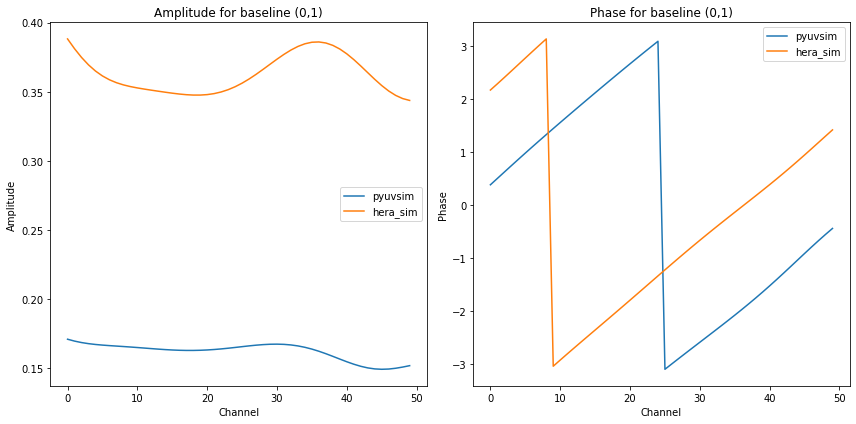

In [4]:
compare(pyuvsim_uvd, simulator.uvdata, pyuvsim_time, hera_sim_time, ant1=0, ant2=1, which_freq=0, which_time=0)

*RESULT : hera_sim is fast, but the output values don't match pyuvsim.*

## Compare enhanced hera_sim against pyuvsim

**Run hera_sim using enhancements**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50 (as before)

In [5]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=50, nfreq=50, ntime=1, nsource=50)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        precision = 2,
        # These parameters use the enhancements
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ]
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start



Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.009277


Brief explanation of the new parameters used:
```
split_I = True
    pyuvsim splits the source intensity between XX and YY pols. hera_sim must do this.
use_pixel_beams = False
    Don't convert the beam to pixels. Interpolate the beam analytically.
az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ]
    Use astropy to calculate az/za angles for beam interpolation. 
    Precompute these values for all times.
    Apply the pyuvsim UVBeam correction to the azimuth. The azimuth gets rotated.
```
*It is important to apply the UVBeam azimuth correction when using PerturbedPolyBeam, because the beam is not symmetrical.*

The "precompute" option is important for hera_sim speed. hera_sim has a loop that recalculates the source az/za for every frequency. Since the source az/za doesn't change by frequency (not here anyway), this is unnecessary. The source az/za can be calculated once.

**Compare**

Use the previous pyuvsim result, which has the same configuration. Make the same comparisons as before. hera_sim visibilities now match pyuvsim.

pyuvsim time: 78.1554594039917
hera_sim time: 0.32687807083129883

---------------------------------- Accuracy --------------------------------------
Values from Channel 0 Time 0
				 pyuvsim 			 hera_sim
Auto corr ant 0 		 0.25656533815007254 		 0.25656533815007254
Cross corr ant (0,1) Amplitude 	 0.17087283751552645 		 0.17087283751552657
Cross corr ant (0,1) Phase 	 0.384381003442964 		 0.3843810034429456



Plots of baseline(0,1) Time 0


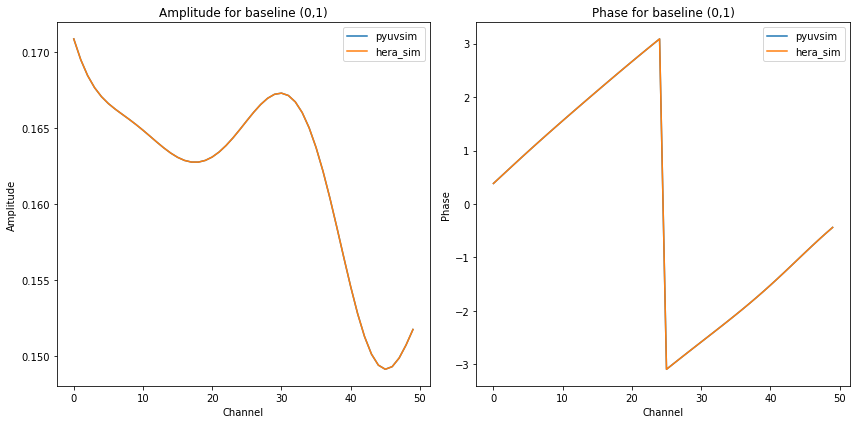

In [6]:
compare(pyuvsim_uvd, simulator.uvdata, pyuvsim_time, hera_sim_time, ant1=0, ant2=1, which_freq=0, which_time=0)

The hera_sim values are so close to pyuvsim, that they can't be distinguished in the plot.

*RESULT : hera_sim is 100s of times faster than pyusim for the same accuracy.*

# 4. Additional test cases


These demonstrate that the previous test case is not a "one off". Use different numbers of ants/frequencies/times/sources, and look at different values.

## Case 1

Different configuration. Antennas: 10, Frequencies: 120, Times: 10, Sources: 100.

**Run hera_sim**

In [7]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=10, nfreq=120, ntime=10, nsource=100)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ],
        precision = 2
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start

Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.088712


**Run pyuvsim**

In [8]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=10, nfreq=120, ntime=10, nsource=100)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start

Nbls: 55
Ntimes: 10
Nfreqs: 120
Nsrcs: 100
Tasks:  66000.0
1.00% completed. 0:00:00.825832  elapsed. 0:01:21.757357 remaining. 

2.00% completed. 0:00:01.635790  elapsed. 0:01:20.153692 remaining. 

3.00% completed. 0:00:02.443084  elapsed. 0:01:18.993042 remaining. 

4.00% completed. 0:00:03.253798  elapsed. 0:01:18.091164 remaining. 

5.00% completed. 0:00:04.065029  elapsed. 0:01:17.235549 remaining. 

6.00% completed. 0:00:04.878466  elapsed. 0:01:16.429295 remaining. 

7.00% completed. 0:00:05.693086  elapsed. 0:01:15.636719 remaining. 

8.00% completed. 0:00:06.501537  elapsed. 0:01:14.767674 remaining. 

9.00% completed. 0:00:07.317915  elapsed. 0:01:13.992256 remaining. 

10.00% completed. 0:00:08.161359  elapsed. 0:01:13.452232 remaining. 

11.00% completed. 0:00:08.969864  elapsed. 0:01:12.574355 remaining. 

12.00% completed. 0:00:09.775396  elapsed. 0:01:11.686240 remaining. 

13.00% completed. 0:00:10.579448  elapsed. 0:01:10.800924 remaining. 

14.00% completed. 0:00:11.3

pyuvsim time: 82.16595220565796
hera_sim time: 0.32687807083129883

---------------------------------- Accuracy --------------------------------------
Values from Channel 100 Time 3
				 pyuvsim 			 hera_sim
Auto corr ant 5 		 0.25346837824535984 		 0.2534683782453598
Cross corr ant (5,7) Amplitude 	 0.10915574854972665 		 0.10915574854972793
Cross corr ant (5,7) Phase 	 1.4179611001259622 		 1.4179611001259473



Plots of baseline(5,7) Time 3


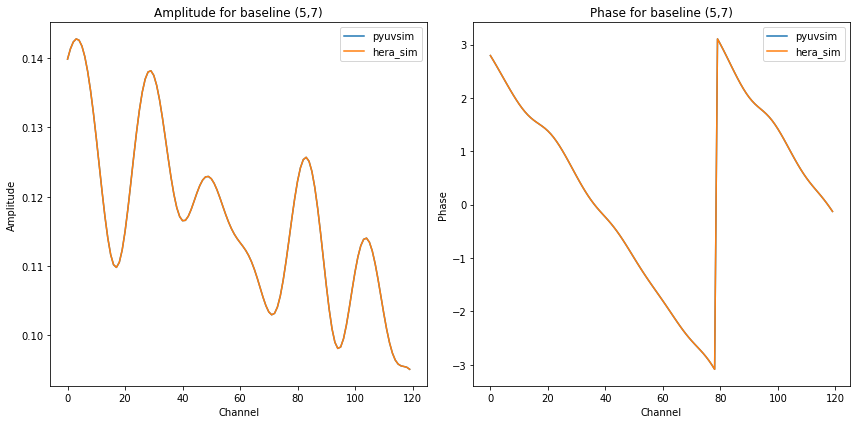

In [9]:
compare(pyuvsim_uvd, simulator.uvdata, pyuvsim_time, hera_sim_time, ant1=5, ant2=7, which_freq=100, which_time=3)

*RESULT : hera_sim still fast and accurate.*

## Case 2

Antennas: 20, Frequencies: 4, Times: 100, Sources: 1000.

**Run hera_sim**

In [10]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=20, nfreq=4, ntime=100, nsource=1000)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ],
        precision = 2
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start

Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.909428


**Run pyuvsim**

In [11]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=20, nfreq=4, ntime=100, nsource=1000)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start

Nbls: 210
Ntimes: 100
Nfreqs: 4
Nsrcs: 1000
Tasks:  84000.0
1.00% completed. 0:00:01.891547  elapsed. 0:03:07.263149 remaining. 

2.00% completed. 0:00:03.773725  elapsed. 0:03:04.912503 remaining. 

3.00% completed. 0:00:05.661625  elapsed. 0:03:03.059221 remaining. 

4.00% completed. 0:00:07.550523  elapsed. 0:03:01.212553 remaining. 

5.00% completed. 0:00:09.465349  elapsed. 0:02:59.841639 remaining. 

6.00% completed. 0:00:11.352921  elapsed. 0:02:57.862422 remaining. 

7.00% completed. 0:00:13.249578  elapsed. 0:02:56.030105 remaining. 

8.00% completed. 0:00:15.142560  elapsed. 0:02:54.139437 remaining. 

9.00% completed. 0:00:17.058236  elapsed. 0:02:52.477721 remaining. 

10.00% completed. 0:00:19.000728  elapsed. 0:02:51.006555 remaining. 

11.00% completed. 0:00:20.909914  elapsed. 0:02:49.180215 remaining. 

12.00% completed. 0:00:22.789401  elapsed. 0:02:47.122273 remaining. 

13.00% completed. 0:00:24.709038  elapsed. 0:02:45.360488 remaining. 

14.00% completed. 0:00:26.

pyuvsim time: 191.52164769172668
hera_sim time: 0.32687807083129883

---------------------------------- Accuracy --------------------------------------
Values from Channel 3 Time 40
				 pyuvsim 			 hera_sim
Auto corr ant 4 		 1.5138302265573047 		 1.5138302265573045
Cross corr ant (4,18) Amplitude 	 0.07026149336152489 		 0.07026149336152546
Cross corr ant (4,18) Phase 	 -2.5768727741044004 		 -2.5768727741043764



Plots of baseline(4,18) Time 40


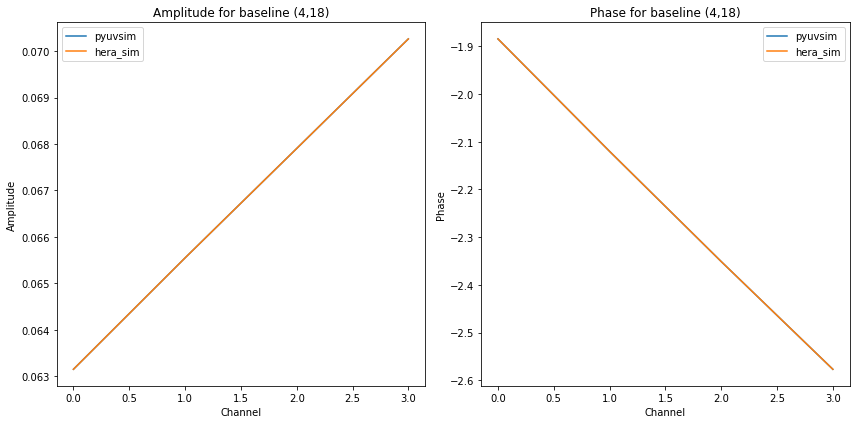

In [12]:
compare(pyuvsim_uvd, simulator.uvdata, pyuvsim_time, hera_sim_time, ant1=4, ant2=18, which_freq=3, which_time=40)

*RESULT : hera_sim still fast and accurate.*

# 5. Performance of enhanced hera_sim vs. pyuvsim at large scales


Each parameter (antennas/frequencies/times/sources) is scaled up while holding the others constant.

Method:

- Start with these parameters: Antennas=10, Frequencies=10, Times=10, Sources=10
- Pick one of those parameters. Increase its value and measure the simulation time and memory use. For both hera_sim and pyuvsim.
- Plot the results.


For each parameter there will be two plots:
- Simulation Time versus parameter value 
- Memory usage versus parameter value

The number of antennas will be plotted as the number of *baselines*. 

Simulations were run on ILIFU in South Africa. No MPI is used, these are all serial runs. The maximum allowed run time was 72 hours. The maximum allowed memory was 232GB. Some pyuvsim runs failed to complete because of these limits. That will be seen in the plots, where the pyuvsim plot does extend over the complete x-axis range.



### Increase number of baselines

**Simulation time**
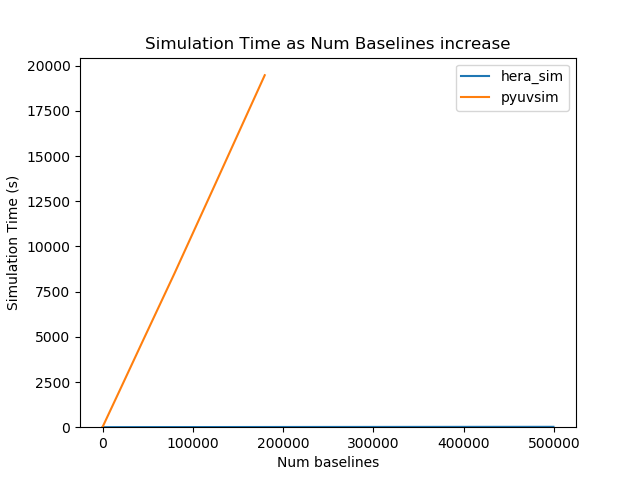

As hera_sim is not visibile in this plot, I show the same plot but clipped on the y-axis:
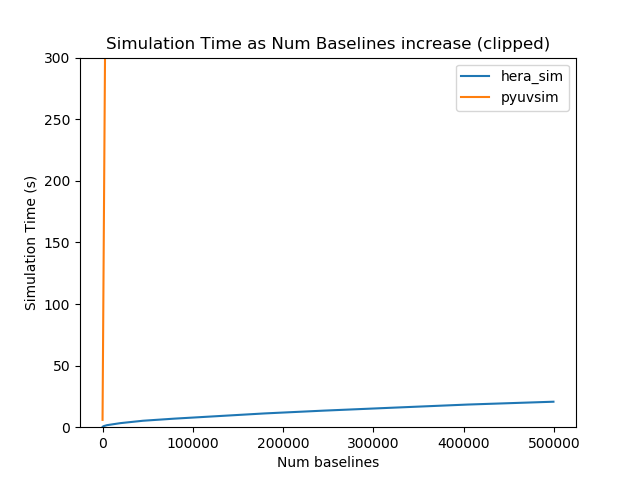

**Memory usage**

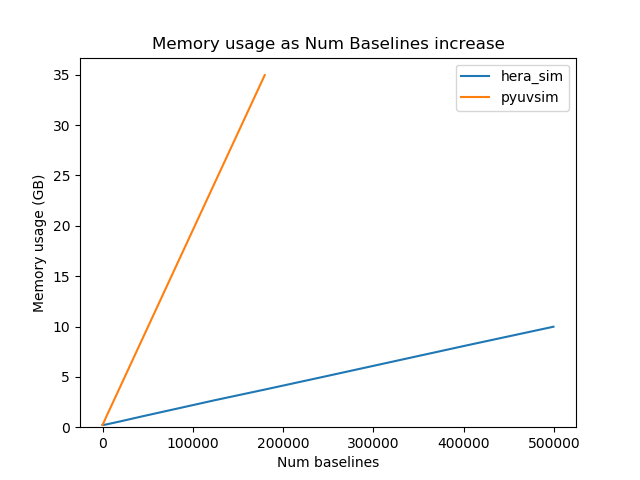
### Increase number of frequencies

**Simulation time**
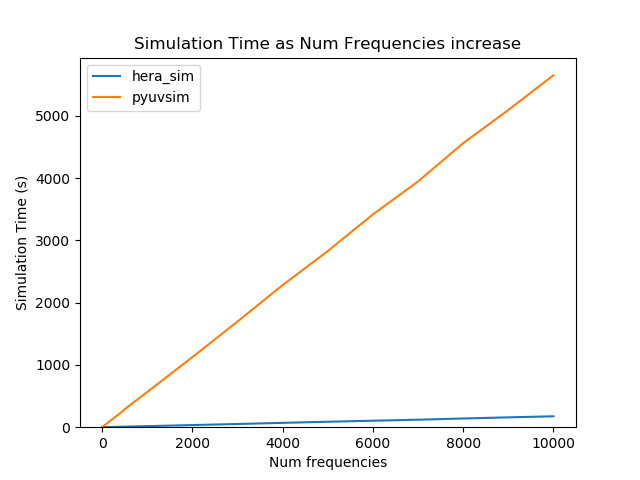

**Memory usage**
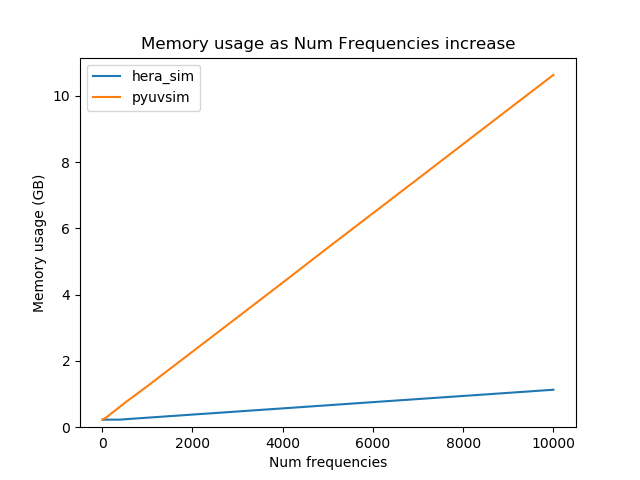

### Increase number of times

**Simulation time**
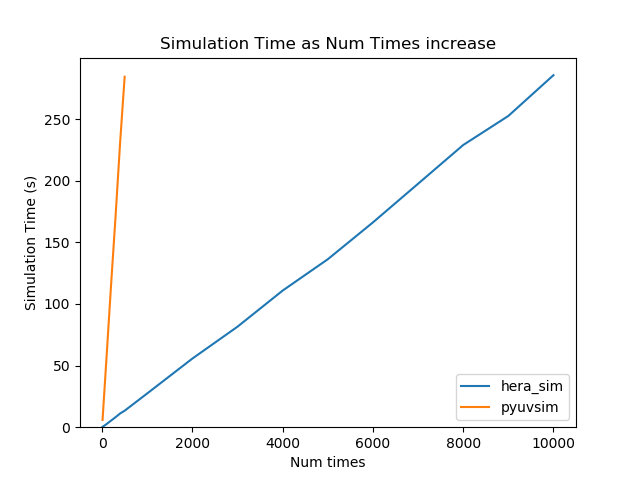
**Memory usage**
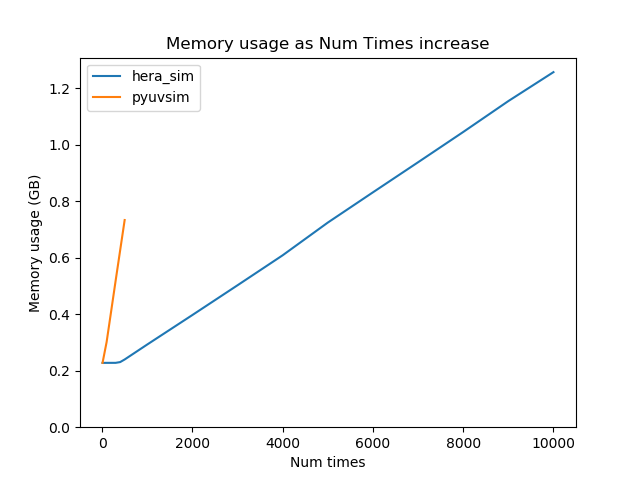

### Increase number of sources

**Simulation time**
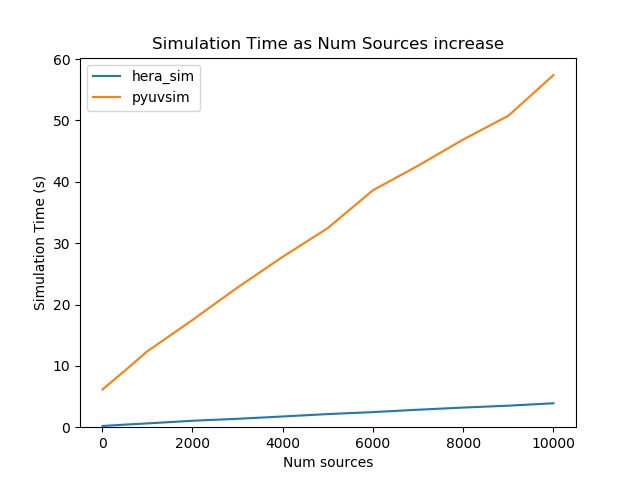

**Memory usage**
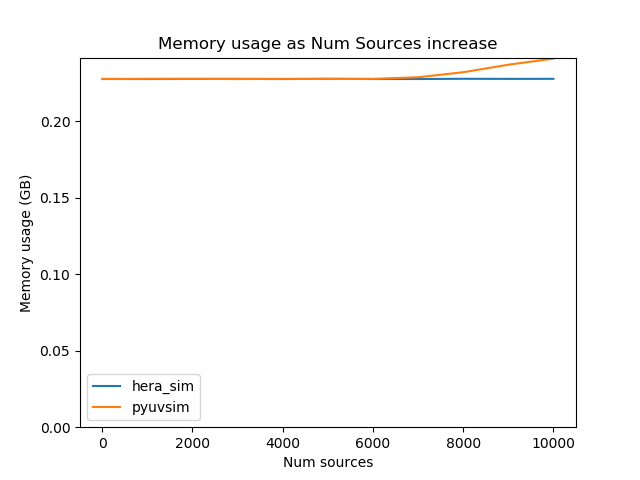


